# Australian Open 2026 Champion Prediction (Men)

This notebook builds a leakage safe match prediction model (Elo + recent form) and estimates Australian Open 2026 title probabilities by Monte Carlo simulation of the official Round 1 draw.

**Main steps**
1. Load match data
2. Normalize player IDs
3. Build leakage-safe features (pre-match Elo and rolling form)
4. Train + evaluate a probabilistic match model
5. Simulate the bracket using the official Round 1 draw
6. Visualize champion probabilities



## 1) Setup

In [1]:
import re
import random
import unicodedata
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss, brier_score_loss

import matplotlib.pyplot as plt


## 2) Load data

In [2]:
ATP_CSV_PATH = "atp_tennis.csv"      # historical matches
ODDS_2026_PATH = "2026.xlsx"        # early 2026 matches (pre-AO)

atp_tennis = pd.read_csv(ATP_CSV_PATH)
odds_2026 = pd.read_excel(ODDS_2026_PATH)

print('ATP rows:', len(atp_tennis), 'Odds 2026 rows:', len(odds_2026))
print('ATP columns:', list(atp_tennis.columns))
print('Odds columns:', list(odds_2026.columns))


ATP rows: 66681 Odds 2026 rows: 58
ATP columns: ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score']
Odds columns: ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment', 'B365W', 'B365L', 'PSW', 'PSL', 'MaxW', 'MaxL', 'AvgW', 'AvgL', 'BFEW', 'BFEL']


## 3) Normalize player IDs

In [3]:
def normalize_ascii(s: str) -> str:
    """Lowercase + remove accents/punctuation noise; keep hyphens and apostrophes."""
    s = str(s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    s = s.lower().strip()
    s = s.replace('’', "'")
    s = s.replace('.', '')
    s = re.sub(r"\s+", " ", s)
    return s

def to_draw_id(name: str) -> str:
    """Convert a name into draw-style id: 'last firstInitial'.

    Handles:
    - 'federer r.' -> 'federer r'
    - 'roger federer' -> 'federer r'
    - 'auger-aliassime f' -> 'auger-aliassime f'
    """
    s = normalize_ascii(name)
    parts = s.split()
    if len(parts) == 1:
        return s

    # if last token is an initial (e.g., 'federer r')
    if len(parts[-1]) == 1:
        last = ' '.join(parts[:-1])
        ini = parts[-1]
        return f"{last} {ini}".strip()

    # otherwise treat as full name 'first last'
    ini = parts[0][0]
    last = ' '.join(parts[1:])
    return f"{last} {ini}".strip()


## 4) Build match table (historical + early 2026)

In [5]:
# Historical ATP
atp = atp_tennis.copy()

def get_loser(row):
    if row['Winner'] == row['Player_1']:
        return row['Player_2']
    if row['Winner'] == row['Player_2']:
        return row['Player_1']
    return None

atp['Loser'] = atp.apply(get_loser, axis=1)

base_matches = (
    atp.dropna(subset=['Date', 'Surface', 'Winner', 'Loser'])
       .rename(columns={'Date':'date','Surface':'surface','Tournament':'tournament','Round':'round','Winner':'winner','Loser':'loser'})
       [['date','surface','tournament','round','winner','loser']]
)

# Convert 'date' column to datetime objects for base_matches
base_matches['date'] = pd.to_datetime(base_matches['date'], errors='coerce')

# Early 2026 (pre-AO)
od = odds_2026.copy()

od['Date'] = pd.to_datetime(od['Date'], errors='coerce')

od = (
    od.dropna(subset=['Date','Surface','Winner','Loser'])
      .rename(columns={'Date':'date','Surface':'surface','Tournament':'tournament','Round':'round','Winner':'winner','Loser':'loser'})
      [['date','surface','tournament','round','winner','loser']]
)

combined = (
    pd.concat([base_matches, od], ignore_index=True)
      .sort_values('date')
      .reset_index(drop=True)
)

print('combined rows:', len(combined), 'date max:', combined['date'].max())

combined rows: 66739 date max: 2026-01-11 00:00:00


## 5) Leakage-safe Elo + rolling form

In [6]:
def expected_score(r_a, r_b):
    return 1 / (1 + 10 ** ((r_b - r_a) / 400))

def update_elo(r_w, r_l, k=32):
    e_w = expected_score(r_w, r_l)
    return r_w + k * (1 - e_w), r_l + k * (0 - (1 - e_w))

# Elo dictionaries
elo_overall = {}
elo_hard = {}

# Rolling history for form features
hist = defaultdict(list)

# Building a modeling table with pre-match features
ml_rows = []

for _, row in combined.iterrows():
    # Only model men's matches on hard for AO-focused model
    date = row['date']
    surf = row['surface']

    w = to_draw_id(row['winner'])
    l = to_draw_id(row['loser'])

    # init ratings
    if w not in elo_overall: elo_overall[w] = 1500.0
    if l not in elo_overall: elo_overall[l] = 1500.0
    if w not in elo_hard: elo_hard[w] = 1500.0
    if l not in elo_hard: elo_hard[l] = 1500.0

    # pre-match ratings
    w_elo_pre = elo_overall[w]
    l_elo_pre = elo_overall[l]
    w_hard_pre = elo_hard[w]
    l_hard_pre = elo_hard[l]

    # pre-match form (only from past)
    def get_form(pid):
        past = hist.get(pid, [])
        hard = [x[0] for x in past if x[1] == 'Hard']
        allw = [x[0] for x in past]
        f10 = float(np.mean(hard[-10:])) if hard else 0.5
        f20 = float(np.mean(allw[-20:])) if allw else 0.5
        return f10, f20

    w_f10, w_f20 = get_form(w)
    l_f10, l_f20 = get_form(l)

    # Create two rows to remove left/right bias
    ml_rows.append({
        'date': date,
        'surface': surf,
        'player_a': w,
        'player_b': l,
        'y': 1,
        'elo_diff': w_elo_pre - l_elo_pre,
        'elo_hard_diff': w_hard_pre - l_hard_pre,
        'form_10_hard': w_f10 - l_f10,
        'form_20_all': w_f20 - l_f20,
    })
    ml_rows.append({
        'date': date,
        'surface': surf,
        'player_a': l,
        'player_b': w,
        'y': 0,
        'elo_diff': l_elo_pre - w_elo_pre,
        'elo_hard_diff': l_hard_pre - w_hard_pre,
        'form_10_hard': l_f10 - w_f10,
        'form_20_all': l_f20 - w_f20,
    })

    # update Elo after match
    elo_overall[w], elo_overall[l] = update_elo(elo_overall[w], elo_overall[l])
    if surf == 'Hard':
        elo_hard[w], elo_hard[l] = update_elo(elo_hard[w], elo_hard[l])

    # update history after match
    hist[w].append((1, surf))
    hist[l].append((0, surf))

ml = pd.DataFrame(ml_rows)
ml_hard = ml[ml['surface'] == 'Hard'].copy()
print('Hard matches for ML:', len(ml_hard))


Hard matches for ML: 72548


## 6) Train + evaluate match model (time split)

In [7]:
features = ['elo_diff','elo_hard_diff','form_10_hard','form_20_all']

split_date = pd.Timestamp('2025-01-01')
train = ml_hard[ml_hard['date'] < split_date]
test  = ml_hard[ml_hard['date'] >= split_date]

X_train, y_train = train[features], train['y']
X_test, y_test   = test[features], test['y']

gb_model = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.05,
    n_estimators=250,
    max_depth=3
)

gb_model.fit(X_train, y_train)

p_test = gb_model.predict_proba(X_test)[:, 1]
print('GB LogLoss:', float(log_loss(y_test, p_test)))
print('GB Brier:', float(brier_score_loss(y_test, p_test)))


GB LogLoss: 0.6251407203920334
GB Brier: 0.21828173227005418


## 7) Build the official Round 1 draw

In [8]:
draw_raw = [
"C. Alcaraz 1",
"A. Walton",
"Y. Hanfmann",
"Z. Svajda Q",
"M. Zheng Q",
"S. Korda",
"T. Schoolkate",
"C. Moutet 32",
"T. Paul 19",
"A. Kovacevic",
"T. Tirante",
"A. Vukic",
"N. Budkov Kjaer Q",
"R. Opelka",
"F. Misolic",
"A. Davidovich Fokina 14",
"A. Bublik 10",
"J. Brooksby",
"C. Ugo Carabelli",
"M. Fucsovics",
"M. Kecmanovic",
"T. Etcheverry",
"A. Fery Q",
"F. Cobolli 20",
"F. Tiafoe 29",
"J. Kubler Q",
"P. Kypson WC",
"F. Comesana",
"M. Navone",
"H. Medjedovic",
"M. McDonald LL",
"A. de Minaur 6",
"A. Zverev 3",
"G. Diallo",
"A. Popyrin",
"A. Muller",
"E. Nava",
"K. Jacquet WC",
"B. Bonzi",
"C. Norrie 26",
"F. Cerundolo 18",
"Z. Zhang",
"L. Draxl Q",
"D. Dzumhur",
"A. Blockx LL",
"J. Faria Q",
"M. Arnaldi",
"A. Rublev 13",
"D. Medvedev 11",
"J. de Jong",
"Q. Halys",
"A. Tabilo",
"K. Majchrzak",
"J. Fearnley",
"F. Marozsan",
"A. Rinderknech 24",
"L. Tien 25",
"M. Giron",
"E. Ymer Q",
"A. Shevchenko",
"J. Cerundolo",
"J. Thompson WC",
"N. Borges",
"F. Auger-Aliassime 7",
"L. Musetti 5",
"R. Collignon",
"L. Sonego",
"C. Taberner",
"G. Dimitrov",
"T. Machac",
"S. Mochizuki",
"S. Tsitsipas 31",
"J. Lehecka 17",
"A. Gea Q",
"L. Djere",
"S. Wawrinka WC",
"V. Kopriva",
"J. Struff",
"V. Royer",
"T. Fritz 9",
"J. Mensik 16",
"P. Carreno Busta",
"R. Sakamoto Q",
"R. Jodar Q",
"H. Hurkacz",
"Z. Bergs",
"E. Quinn",
"T. Griekspoor 23",
"B. Nakashima 27",
"B. van de Zandschulp",
"J. Shang",
"R. Bautista Agut",
"T. Atmane",
"F. Maestrelli Q",
"P. Martinez",
"N. Djokovic 4",
"B. Shelton 8",
"U. Humbert",
"D. Sweeny Q",
"G. Monfils",
"A. Mannarino",
"R. Hijikata WC",
"M. Damm Q",
"V. Vacherot 30",
"D. Shapovalov 21",
"Y. Bu WC",
"D. Altmaier",
"M. Cilic",
"J. Munar",
"D. Svrcina",
"M. Bellucci",
"C. Ruud 12",
"K. Khachanov 15",
"A. Michelsen",
"C. O'Connell WC",
"N. Basavareddy Q",
"G. Mpetshi Perricard",
"S. Baez",
"C. Garin",
"L. Darderi 22",
"J. Fonseca 28",
"E. Spizzirri",
"L. Nardi",
"Y. Wu Q",
"J. Duckworth WC",
"D. Prizmic LL",
"H. Gaston",
"J. Sinner 2"
]

def clean_draw_name(name: str) -> str:
    name = re.sub(r"(Q|WC|LL)", "", name)
    name = re.sub(r"\d+", "", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

def drawname_to_id(draw_name: str) -> str:
    s = normalize_ascii(clean_draw_name(draw_name))
    parts = s.split()
    if len(parts) < 2:
        return s.strip()
    ini = parts[0]
    last = ' '.join(parts[1:])
    return f"{last} {ini}".strip()

draw_clean = [clean_draw_name(n) for n in draw_raw if str(n).strip()]
draw_ids = [drawname_to_id(n) for n in draw_clean]

assert len(draw_ids) == 128, f"Expected 128 draw slots, got {len(draw_ids)}"

draw_dict = {i+1: draw_ids[i].strip() for i in range(128)}

# Checking missing players
missing_overall = [p for p in draw_dict.values() if p not in elo_overall]
missing_hard = [p for p in draw_dict.values() if p not in elo_hard]
print('Missing overall:', len(missing_overall), missing_overall[:20])
print('Missing hard:', len(missing_hard), missing_hard[:20])


Missing overall: 30 ['svajda q z', 'zheng q m', 'tirante t', 'budkov kjaer q n', 'fery q a', 'kubler q j', 'kypson wc p', 'mcdonald ll m', 'jacquet wc k', 'draxl q l', 'blockx ll a', 'faria q j', 'ymer q e', 'cerundolo j', 'thompson wc j', 'gea q a', 'wawrinka wc s', 'struff j', 'sakamoto q r', 'jodar q r']
Missing hard: 30 ['svajda q z', 'zheng q m', 'tirante t', 'budkov kjaer q n', 'fery q a', 'kubler q j', 'kypson wc p', 'mcdonald ll m', 'jacquet wc k', 'draxl q l', 'blockx ll a', 'faria q j', 'ymer q e', 'cerundolo j', 'thompson wc j', 'gea q a', 'wawrinka wc s', 'struff j', 'sakamoto q r', 'jodar q r']


In [18]:
print('GB LogLoss:', float(log_loss(y_test, p_test)))
print('GB Brier:', float(brier_score_loss(y_test, p_test)))

GB LogLoss: 0.6251407203920334
GB Brier: 0.21828173227005418


## 8) Tournament simulation

In [9]:
import pandas as pd

def get_form_features(player_id, hist_dict):
    past = hist_dict.get(player_id, [])
    hard = [x[0] for x in past if x[1] == 'Hard']
    allw = [x[0] for x in past]
    form_10_hard = float(np.mean(hard[-10:])) if hard else 0.5
    form_20_all  = float(np.mean(allw[-20:])) if allw else 0.5
    return form_10_hard, form_20_all

def match_prob(a, b, model, elo_all, elo_h, hist_dict):
    ea = elo_all.get(a, 1500.0)
    eb = elo_all.get(b, 1500.0)
    ha = elo_h.get(a, 1500.0)
    hb = elo_h.get(b, 1500.0)

    a_f10, a_f20 = get_form_features(a, hist_dict)
    b_f10, b_f20 = get_form_features(b, hist_dict)

    X = pd.DataFrame([{
        'elo_diff': ea - eb,
        'elo_hard_diff': ha - hb,
        'form_10_hard': a_f10 - b_f10,
        'form_20_all': a_f20 - b_f20,
    }])
    return float(model.predict_proba(X)[0, 1])

def simulate_tournament(draw_dict, model, elo_all, elo_h, hist_dict, n_sims=2000, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    bracket = [draw_dict[i] for i in range(1, 129)]
    win_counts = defaultdict(int)

    for _ in range(n_sims):
        players_round = bracket[:]
        while len(players_round) > 1:
            nxt = []
            for i in range(0, len(players_round), 2):
                a, b = players_round[i], players_round[i+1]
                p = match_prob(a, b, model, elo_all, elo_h, hist_dict)
                winner = a if random.random() < p else b
                nxt.append(winner)
            players_round = nxt
        win_counts[players_round[0]] += 1

    probs = {k: v / n_sims for k, v in win_counts.items()}
    return dict(sorted(probs.items(), key=lambda x: x[1], reverse=True))

probs = simulate_tournament(draw_dict, gb_model, elo_overall, elo_hard, hist, n_sims=2000, seed=42)

top15 = list(probs.items())[:15]
pd.DataFrame(top15, columns=['player_id','title_probability'])


,player_id,title_probability
0,sinner j,0.5090
1,alcaraz c,0.2345
2,djokovic n,0.1075
3,zverev a,0.0225
4,auger-aliassime f,0.0185
5,medvedev d,0.0155
6,de minaur a,0.0145
7,fritz t,0.0115
8,dimitrov g,0.0090
9,ruud c,0.0075


## 9) Visualization

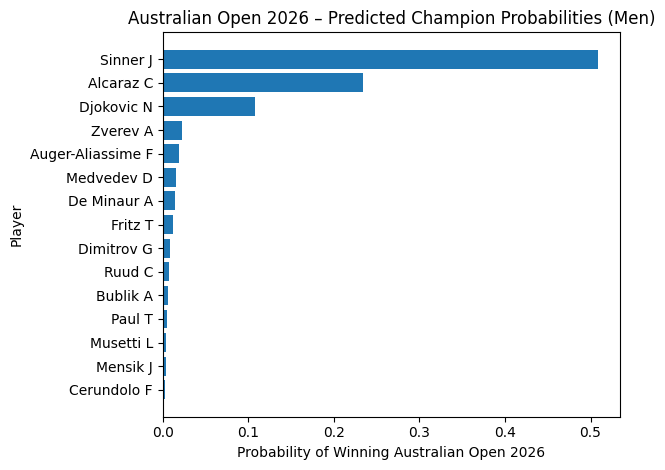

In [15]:
top15 = list(probs.items())[:15]
df = pd.DataFrame(top15, columns=['player','probability'])

df['player'] = df['player'].str.replace('_',' ').str.title()

plt.figure()
plt.barh(df['player'], df['probability'])
plt.xlabel('Probability of Winning Australian Open 2026')
plt.ylabel('Player')
plt.title('Australian Open 2026 – Predicted Champion Probabilities (Men)')
plt.gca().invert_yaxis()
plt.tight_layout()

# Save for GitHub + LinkedIn
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/ao_2026_champion_probabilities.png', dpi=300)
plt.show()


In [16]:
df_top5 = df.head(5)
print(df_top5)

              player  probability
0           Sinner J       0.5090
1          Alcaraz C       0.2345
2         Djokovic N       0.1075
3           Zverev A       0.0225
4  Auger-Aliassime F       0.0185


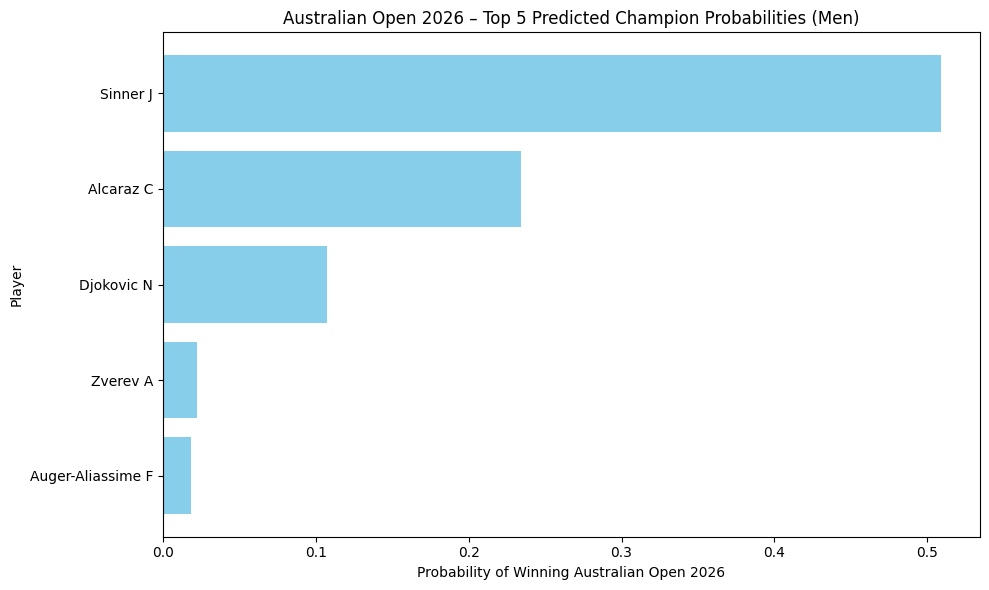

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(df_top5['player'], df_top5['probability'], color='skyblue')
plt.xlabel('Probability of Winning Australian Open 2026')
plt.ylabel('Player')
plt.title('Australian Open 2026 – Top 5 Predicted Champion Probabilities (Men)')
plt.gca().invert_yaxis()
plt.tight_layout()

# Save the figure
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/ao_2026_top5_champion_probabilities.png', dpi=300)
plt.show()

## 10) Final prediction

In [11]:
winner_id, winner_p = next(iter(probs.items()))
print('Predicted champion:', winner_id, '| probability:', winner_p)


Predicted champion: sinner j | probability: 0.509


## Predicted Tournament Outcomes

### Champion 🏆
*   Sinner J

### Runner-up 🥈
*   Alcaraz C

### Semi-finalists
*   Djokovic N
*   Zverev A

### Quarter-finalists
*   Auger-Aliassime F
*   Medvedev D
*   Fritz T
*   De Minaur A